In [1]:
import numpy as np

In [2]:
import sys, os
sys.path.insert(0,"/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/")
sys.path.insert(0,os.path.abspath("../PathPretrain"))
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import skimage.io
import numpy as np
import cv2
import cv2, skimage.io
from pathflowai.utils import generate_tissue_mask
compression=8
threshold=220
img=skimage.io.imread("../bcc/interactive_test/163_A1a.img.0.png")
mask=generate_tissue_mask(img,compression=compression,threshold=threshold,keep_holes=False)

nonechucks may not work properly with this version of PyTorch (1.6.0). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


In [28]:
import tqdm, pandas as pd
patch_size=100
ds=100
patches=[]
coords=[]
for x,y in tqdm.tqdm([(x2,y2) for x2 in np.arange(0,img.shape[0]-ds,ds).astype(int) for y2 in np.arange(0,img.shape[1]-ds,ds).astype(int)]):
    if mask[x:x+patch_size,y:y+patch_size].mean()>=0.1:
        patches.append((x,y,img[x:x+patch_size,y:y+patch_size]))#.astype(float)/255.        
patches=pd.DataFrame(patches)
# patches=patches.loc[(patches[2].map(np.mean)>(0.01 if slide1 else 0.1))]



  0%|          | 0/123540 [00:00<?, ?it/s]

  2%|▏         | 2770/123540 [00:00<00:04, 27693.29it/s]

  5%|▌         | 6689/123540 [00:00<00:03, 30365.03it/s]

  9%|▉         | 11714/123540 [00:00<00:03, 34455.11it/s]

 14%|█▎        | 16826/123540 [00:00<00:02, 38189.81it/s]

 18%|█▊        | 21857/123540 [00:00<00:02, 41163.44it/s]

 22%|██▏       | 26925/123540 [00:00<00:02, 43619.99it/s]

 26%|██▌       | 31954/123540 [00:00<00:02, 45427.24it/s]

 30%|██▉       | 36924/123540 [00:00<00:01, 46627.99it/s]

 34%|███▍      | 41802/123540 [00:00<00:01, 47251.50it/s]

 38%|███▊      | 46732/123540 [00:01<00:01, 47845.57it/s]

 42%|████▏     | 51600/123540 [00:01<00:01, 48091.81it/s]

 46%|████▌     | 56506/123540 [00:01<00:01, 48377.08it/s]

 50%|████▉     | 61346/123540 [00:01<00:01, 48382.34it/s]

 54%|█████▎    | 66281/123540 [00:01<00:01, 48668.23it/s]

 58%|█████▊    | 71157/123540 [00:01<00:01, 48693.90it/s]

 62%|██████▏   | 76098/123540 [00:01<00:00, 48903.85it/s]

 66%|██████▌

In [20]:
# patches.loc[:,2]=patches[2].map(lambda x: np.transpose(x,(2,0,1)))

In [29]:
patches[2].iloc[0].shape

(100, 100, 3)

In [8]:
! ls seg_model

0.checkpoint.pth  3.checkpoint.pth  6.checkpoint.pth
1.checkpoint.pth  4.checkpoint.pth  7.checkpoint.pth
2.checkpoint.pth  5.checkpoint.pth  8.checkpoint.pth


In [44]:
from torch.utils.data import Dataset
import torch, pandas as pd, numpy as np
from PIL import Image
class WSI_Dataset(Dataset):
    def __init__(self, patches, transform):
        self.patches=patches
        self.to_pil=lambda x: Image.fromarray(x)
        self.length=len(self.patches)
        self.transform=transform
        
    def __getitem__(self,idx):
        X=self.transform(self.to_pil(self.patches.iloc[idx,2]))
        return X,torch.zeros(X.shape[-2:]).unsqueeze(0).long()
    
    def __len__(self):
        return self.length

In [45]:
from train_model import train_model, generate_transformers, generate_kornia_transforms
transform=generate_transformers(256,256)['test']
custom_dataset=WSI_Dataset(patches,transform)

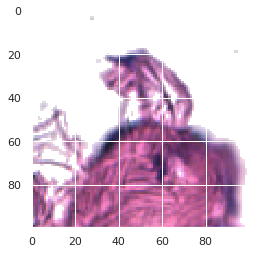

In [39]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(np.transpose(patches.iloc[0,2],(0,1,2)))

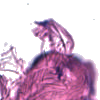

In [43]:
custom_dataset.to_pil(patches.iloc[0,2])

In [47]:
! nvidia-smi

Fri Oct 23 11:31:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   44C    P0    55W / 300W |  13348MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   30C    P0    39W / 300W |     11MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [48]:
from torch.utils.data import Dataset
seg_model="seg_model/27.checkpoint.pth" # was 8.
Y_seg=train_model(inputs_dir='inputs',
                architecture='resnet50',
                batch_size=512,
                num_classes=2,
                predict=True,
                model_save_loc=seg_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=0,
                tensor_dataset=False,
                semantic_segmentation=True,
                custom_dataset=custom_dataset,
                save_predictions=False)['pred'] # going to need distributed inference engine




  0%|          | 0/165 [00:00<?, ?it/s]


  1%|          | 1/165 [00:02<05:59,  2.19s/it]


  1%|          | 2/165 [00:04<05:59,  2.21s/it]


  2%|▏         | 3/165 [00:06<05:56,  2.20s/it]


  2%|▏         | 4/165 [00:08<05:53,  2.20s/it]


  3%|▎         | 5/165 [00:10<05:47,  2.17s/it]


  4%|▎         | 6/165 [00:13<05:44,  2.17s/it]


  4%|▍         | 7/165 [00:15<05:45,  2.18s/it]


  5%|▍         | 8/165 [00:17<05:40,  2.17s/it]


  5%|▌         | 9/165 [00:19<05:40,  2.18s/it]


  6%|▌         | 10/165 [00:21<05:38,  2.18s/it]


  7%|▋         | 11/165 [00:23<05:33,  2.17s/it]


  7%|▋         | 12/165 [00:26<05:42,  2.24s/it]


  8%|▊         | 13/165 [00:28<05:41,  2.25s/it]


  8%|▊         | 14/165 [00:30<05:36,  2.23s/it]


  9%|▉         | 15/165 [00:33<05:33,  2.22s/it]


 10%|▉         | 16/165 [00:35<05:30,  2.22s/it]


 10%|█         | 17/165 [00:37<05:28,  2.22s/it]


 11%|█         | 18/165 [00:39<05:25,  2.21s/it]


 12%|█▏        | 19/165 [00:41<05:23,  2.21s/i

 82%|████████▏ | 136/165 [04:56<01:02,  2.15s/it]


 83%|████████▎ | 137/165 [04:58<01:00,  2.14s/it]


 84%|████████▎ | 138/165 [05:00<00:58,  2.16s/it]


 84%|████████▍ | 139/165 [05:03<00:55,  2.15s/it]


 85%|████████▍ | 140/165 [05:05<00:53,  2.16s/it]


 85%|████████▌ | 141/165 [05:07<00:52,  2.20s/it]


 86%|████████▌ | 142/165 [05:09<00:50,  2.18s/it]


 87%|████████▋ | 143/165 [05:11<00:47,  2.17s/it]


 87%|████████▋ | 144/165 [05:13<00:45,  2.18s/it]


 88%|████████▊ | 145/165 [05:16<00:43,  2.18s/it]


 88%|████████▊ | 146/165 [05:18<00:41,  2.18s/it]


 89%|████████▉ | 147/165 [05:20<00:39,  2.17s/it]


 90%|████████▉ | 148/165 [05:22<00:36,  2.16s/it]


 90%|█████████ | 149/165 [05:24<00:34,  2.15s/it]


 91%|█████████ | 150/165 [05:26<00:32,  2.16s/it]


 92%|█████████▏| 151/165 [05:29<00:30,  2.17s/it]


 92%|█████████▏| 152/165 [05:31<00:28,  2.17s/it]


 93%|█████████▎| 153/165 [05:33<00:25,  2.16s/it]


 93%|█████████▎| 154/165 [05:35<00:23,  2.16s/it]


 94%|███████

In [ ]:
# when placing them back down resize to 100
# maybe just save them here for now 
# nearest neighbor interpolation
# argmax and nearest neighbor interpolation
# mix in regions that tissue mask exists in

f003k8w  269564 38.0  0.0   4632   668 pts/1    Ss+  12:24   0:00 /bin/sh -c  ps aux | grep 3_7
f003k8w  269566  0.0  0.0  11456   728 pts/1    R+   12:24   0:00 grep 3_7


In [54]:
import pickle
# pickle.dump(Y_seg,open('nuclei_test.pkl','wb'),protocol=4) # just to save checkpoint

In [55]:
Y_pred=Y_seg.argmax(1)

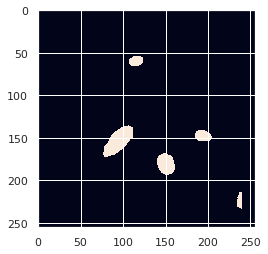

In [57]:
plt.imshow(Y_pred[0])

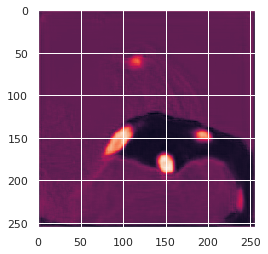

In [80]:
plt.imshow(Y_seg[0,1])

In [58]:
np.save("nuclei_test.npy",Y_pred)

In [60]:
Y_pred.shape

(84884, 256, 256)

In [62]:
import torch.nn
Y_pred_new=torch.nn.functional.interpolate(torch.tensor(Y_pred).unsqueeze(1).float(), size=(100,100), mode='nearest', align_corners=None).squeeze(1).long().numpy()


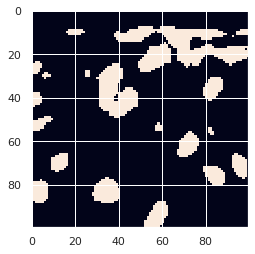

In [78]:
# plt.imshow(cv2.blur(Y_pred_new[4], (2, 2)))


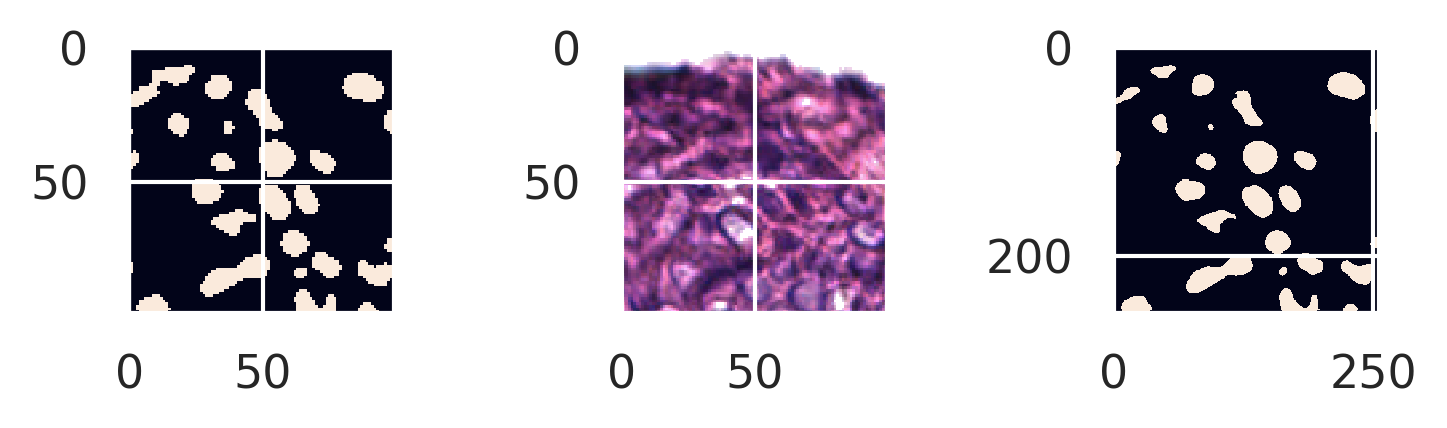

In [98]:
from scipy.special import softmax
matplotlib.rcParams['figure.dpi']=300
i=5
plt.subplot(331)
plt.imshow(Y_pred_new[i])
plt.subplot(332)
plt.imshow(patches.iloc[i,2])
plt.subplot(333)
plt.imshow(softmax(Y_seg[i],0)[1]>0.9)

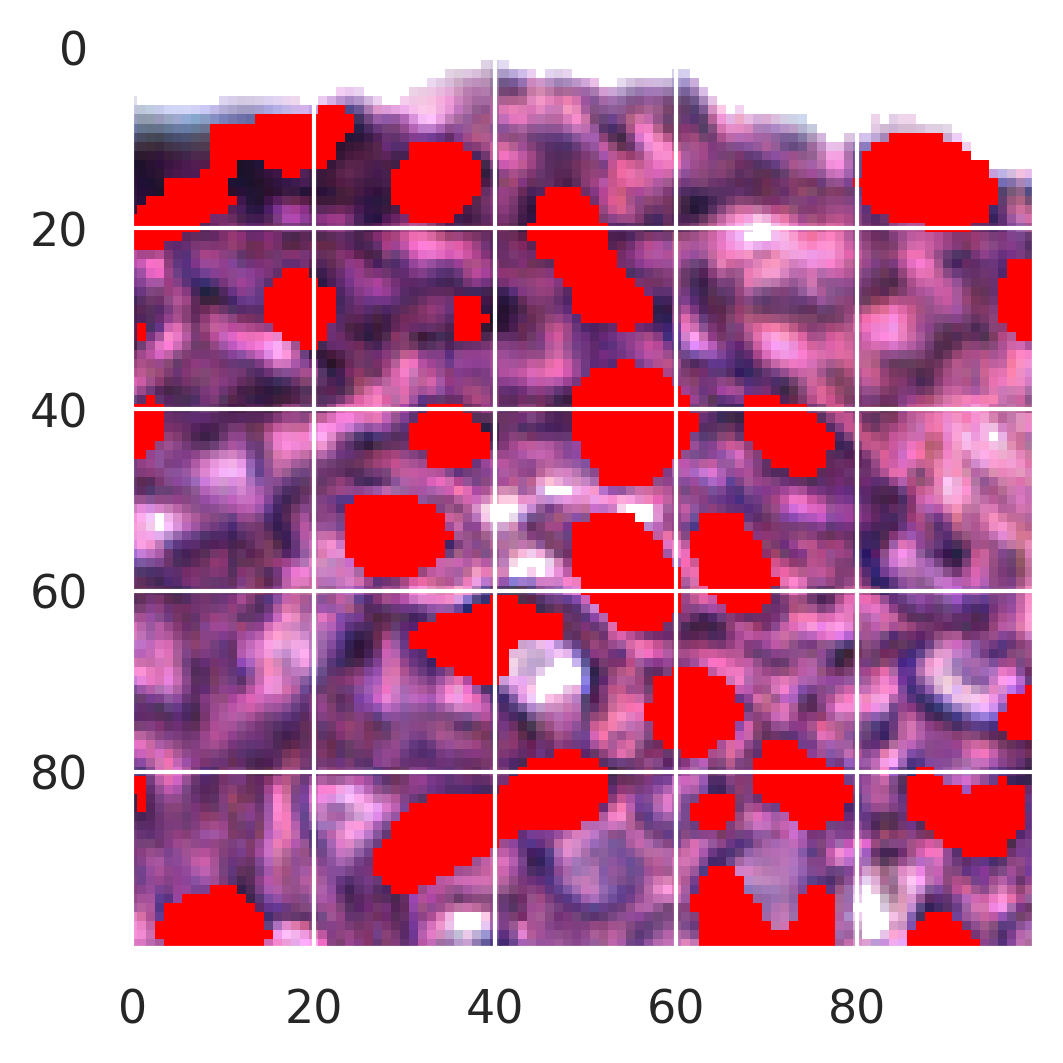

In [104]:
im_=patches.iloc[i,2].copy()
im_[Y_pred_new[i]==1,...]=[255,0,0]
plt.imshow(im_)

In [110]:
img.shape

(34816, 35584, 3)

In [111]:
from tqdm import trange
pred_mask=np.zeros(img.shape[:2])
for i in trange(Y_pred_new.shape[0]):
    x,y=patches.loc[i,[0,1]]
    pred_mask[x:x+patch_size,y:y+patch_size]=Y_pred_new[i]
pred_mask=pred_mask.astype(bool)
# Y_pred_new




  0%|          | 0/84884 [00:00<?, ?it/s]


  0%|          | 100/84884 [00:00<01:27, 965.92it/s]


  0%|          | 287/84884 [00:00<01:14, 1129.17it/s]


  1%|          | 522/84884 [00:00<01:03, 1337.24it/s]


  1%|          | 770/84884 [00:00<00:54, 1551.00it/s]


  1%|          | 1035/84884 [00:00<00:47, 1770.46it/s]


  2%|▏         | 1290/84884 [00:00<00:43, 1938.65it/s]


  2%|▏         | 1547/84884 [00:00<00:39, 2092.84it/s]


  2%|▏         | 1812/84884 [00:00<00:37, 2233.68it/s]


  2%|▏         | 2069/84884 [00:00<00:35, 2316.39it/s]


  3%|▎         | 2345/84884 [00:01<00:34, 2408.49it/s]


  3%|▎         | 2611/84884 [00:01<00:33, 2477.80it/s]


  3%|▎         | 2883/84884 [00:01<00:32, 2543.56it/s]


  4%|▎         | 3148/84884 [00:01<00:31, 2572.59it/s]


  4%|▍         | 3414/84884 [00:01<00:31, 2580.42it/s]


  4%|▍         | 3698/84884 [00:01<00:30, 2652.56it/s]


  5%|▍         | 3966/84884 [00:01<00:30, 2619.43it/s]


  5%|▌         | 4248/84884 [00:01<00:30, 2674

 41%|████      | 34531/84884 [00:12<00:17, 2874.41it/s]


 41%|████      | 34819/84884 [00:12<00:17, 2871.42it/s]


 41%|████▏     | 35107/84884 [00:12<00:17, 2865.98it/s]


 42%|████▏     | 35410/84884 [00:12<00:16, 2911.05it/s]


 42%|████▏     | 35702/84884 [00:12<00:16, 2898.66it/s]


 42%|████▏     | 35993/84884 [00:13<00:16, 2886.04it/s]


 43%|████▎     | 36282/84884 [00:13<00:16, 2881.43it/s]


 43%|████▎     | 36572/84884 [00:13<00:16, 2883.80it/s]


 43%|████▎     | 36872/84884 [00:13<00:16, 2884.91it/s]


 44%|████▍     | 37175/84884 [00:13<00:16, 2926.79it/s]


 44%|████▍     | 37468/84884 [00:13<00:16, 2914.99it/s]


 44%|████▍     | 37760/84884 [00:13<00:16, 2899.96it/s]


 45%|████▍     | 38051/84884 [00:13<00:16, 2896.74it/s]


 45%|████▌     | 38341/84884 [00:13<00:16, 2887.56it/s]


 46%|████▌     | 38636/84884 [00:13<00:16, 2883.54it/s]


 46%|████▌     | 38937/84884 [00:14<00:15, 2919.48it/s]


 46%|████▌     | 39230/84884 [00:14<00:15, 2905.66it/s]


 47%|████▋    

 82%|████████▏ | 69769/84884 [00:24<00:05, 2786.42it/s]


 83%|████████▎ | 70055/84884 [00:24<00:05, 2806.34it/s]


 83%|████████▎ | 70340/84884 [00:25<00:05, 2817.71it/s]


 83%|████████▎ | 70624/84884 [00:25<00:05, 2824.29it/s]


 84%|████████▎ | 70910/84884 [00:25<00:04, 2834.27it/s]


 84%|████████▍ | 71194/84884 [00:25<00:04, 2795.15it/s]


 84%|████████▍ | 71476/84884 [00:25<00:04, 2800.37it/s]


 85%|████████▍ | 71760/84884 [00:25<00:04, 2810.30it/s]


 85%|████████▍ | 72045/84884 [00:25<00:04, 2819.86it/s]


 85%|████████▌ | 72330/84884 [00:25<00:04, 2827.79it/s]


 86%|████████▌ | 72613/84884 [00:25<00:04, 2783.88it/s]


 86%|████████▌ | 72894/84884 [00:25<00:04, 2789.79it/s]


 86%|████████▌ | 73180/84884 [00:26<00:04, 2808.70it/s]


 87%|████████▋ | 73466/84884 [00:26<00:04, 2821.92it/s]


 87%|████████▋ | 73749/84884 [00:26<00:04, 2783.19it/s]


 87%|████████▋ | 74035/84884 [00:26<00:03, 2803.65it/s]


 88%|████████▊ | 74322/84884 [00:26<00:03, 2820.79it/s]


 88%|████████▊

In [112]:
img2=img.copy()
img2[pred_mask]=[255,0,0]

In [113]:
skimage.io.imsave("../bcc/interactive_test/163_A1a.nuclei.0.png",img2)

In [105]:
# softmax(Y_seg[i],0)#[0].max()

In [ ]:
# mixing, want probability softmax or just prediction??

In [ ]:
# dzi